## Imports

In [8]:
from utils.SpokenDigitDataset import SpokenDigitDataset
from utils.DatasetSplitter import DatasetSplitter
from models.ResNet import ResNet18
from models.MobileNet import MobileNet
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import librosa.display
import wandb
from torch.optim.lr_scheduler import ReduceLROnPlateau



## Dataset

Etiqueta: 0


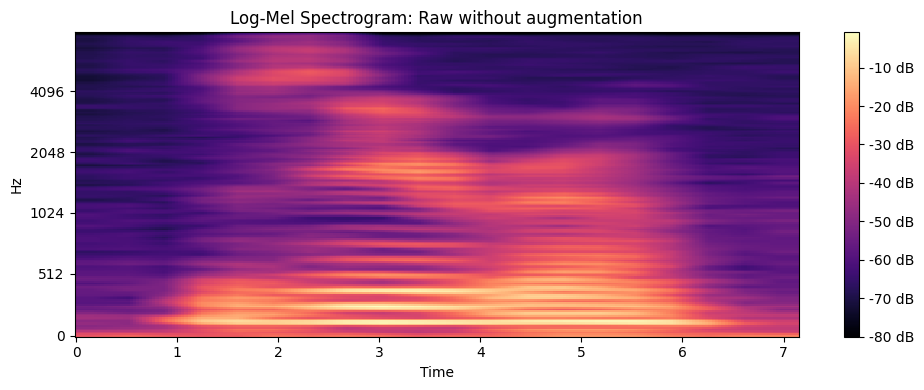

Etiqueta: 0


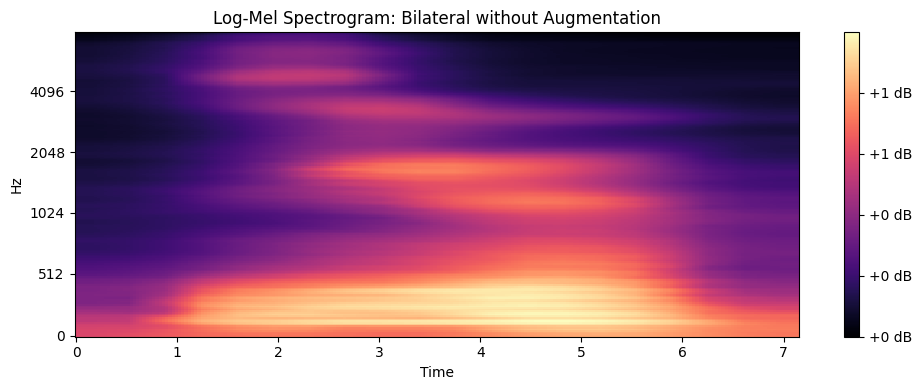

Etiqueta: 0


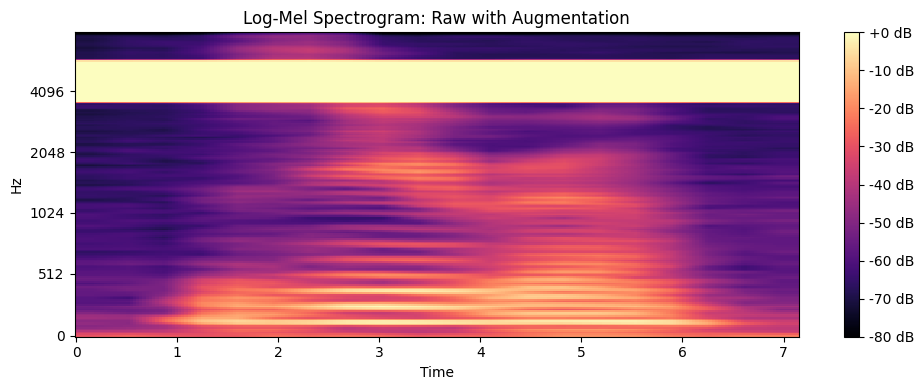

Etiqueta: 0


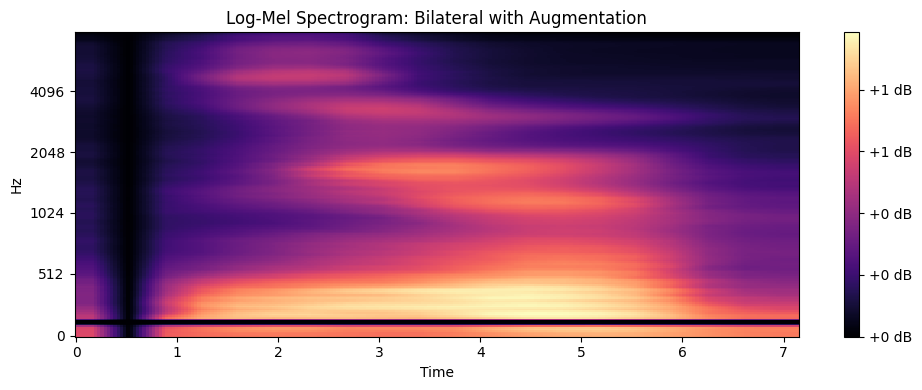

In [9]:
dataset = SpokenDigitDataset("data/audio")

# This will automatically perform the split upon creation
splitter = DatasetSplitter(
        dataset=dataset,
        split_ratios=(0.7, 0.15, 0.15) # Example: 70% train, 15% val, 15% test
)

# You can access the split datasets:
train_set = splitter.train_dataset
val_set = splitter.val_dataset
test_set = splitter.test_dataset

# print(f"\nAccessed train_set (Subset): Size {len(train_set)}")
# print(f"Accessed val_set (Subset): Size {len(val_set)}")
# print(f"Accessed test_set (Subset): Size {len(test_set)}")

# You can configure the underlying dataset for each split
# For example, enable augmentation only for the training set


# Check the configuration of the underlying dataset for a split
# print(f"\nTrain dataset underlying config after configure_splits: Bilateral={train_set.dataset.bilateral}, Augment={train_set.dataset.augment}")
# print(f"Validation dataset underlying config after configure_splits: Bilateral={val_set.dataset.bilateral}, Augment={val_set.dataset.augment}")
# print(f"Test dataset underlying config after configure_splits: Bilateral={test_set.dataset.bilateral}, Augment={test_set.dataset.augment}")


# You can access the DataLoaders:
train_loader = splitter.train_dataloader
val_loader = splitter.val_dataloader
test_loader = splitter.test_dataloader


splitter.configure_splits(bilateral=False, augment=False)
x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Raw without augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=True, augment=False)
x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Bilateral without Augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=False, augment=True)

x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Raw with Augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=True, augment=True)

x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Bilateral with Augmentation')
plt.tight_layout()
plt.show()



## Modelo B (ResNet)

In [10]:
wandb.init(
    project="Audio-mnist",
    name="lenet5-audio-run",
    config={
        "epochs": 15,
        "batch_size": 32,
        "learning_rate": 0.0001,
        "architecture": "LeNet5Audio",
        "input_size": "1x224x224"
    }
)

epoch,▁▃▆█
train/accuracy,▁▅▇█
train/loss,█▄▂▁
validation/loss,█▄▂▁
epoch,4
train/accuracy,80.39048
train/loss,0.74093
validation/loss,0.81756


In [11]:
MINIBATCH_SIZE = 64
NUM_CLASSES = 10 # Para Audio MNIST (dígitos 0-9)
TOTAL_EPOCHS = 20 # Número de épocas para el entrenamiento (ajusta según necesidad)

# Crear el modelo y pasarlo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = ResNet18(num_classes=NUM_CLASSES, in_channels=1) # in_channels=1 para espectrogramas
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

loss_function = torch.nn.CrossEntropyLoss()

# Scheduler OneCycleLR para un entrenamiento eficiente.
# Es MUY RECOMENDABLE usar un "Learning Rate Finder" (ej. de fastai) para determinar el `max_lr` óptimo.
# El `max_lr` generalmente es un valor más alto (ej. 0.01, 0.005, etc.).
# El notebook `DL_fundamentals_ResNet56_1cycle_cifar10.ipynb` usa un LR Finder para esto.
# Aquí se pone un valor de ejemplo. ¡AJÚSTALO!
MAX_LR = 0.01 # **IMPORTANTE: REEMPLAZA ESTO CON EL VALOR ÓPTIMO ENCONTRADO CON UN LR FINDER**

scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=TOTAL_EPOCHS,
    anneal_strategy='cos',
    cycle_momentum=True
)


Usando dispositivo: cpu


In [12]:
def train(training_data_loader, model, loss_function, optimizer, scheduler):
    model.train()
    correct = 0
    losses = []
    for inputs, labels in training_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = loss_function(out, labels)
        losses.append(loss)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == labels).sum().item()
        

    mean_loss = sum(losses)/len(losses)
    mean_acc = correct/len(training_data_loader.dataset) * 100.
    scheduler.step(mean_loss)

    return mean_loss, mean_acc

In [13]:
def validate(validation_data_loader, model, loss_function):
    with torch.no_grad():
        model.train()
        correct = 0
        losses = []
        for inputs, labels in validation_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss = loss_function(out, labels)
            losses.append(loss)
            correct += (out.argmax(1) == labels).sum().item()
        
        mean_loss = sum(losses)/len(losses)
        mean_acc = correct/len(validation_data_loader.dataset) * 100.

        return mean_loss, mean_acc



In [14]:

# for epoch in range(wandb.config.epochs):
#     val_loss, val_acc = validate(val_loader, model, loss_function)
#     mean_loss, mean_acc = train(train_loader, model, loss_function, optimizer, scheduler)
        
#     wandb.log({
#         "epoch": epoch + 1,
#         "train/loss": mean_loss,
#         "train/accuracy": mean_acc,
#         "validation/loss": val_loss
#     })


#     print(f"Epoch {epoch+1}: Loss={mean_loss:.4f}, Validation Loss= {val_loss}  ({(val_loss > mean_acc)}), Accuracy={mean_acc:.2f}%, Validation Accuracy={val_acc}%")

## MobileNet

In [15]:
wandb.init(
    project="Audio-mnist",
    name="mobileNet-audio-run",
    config={
        "epochs": 15,
        "batch_size": 32,
        "learning_rate": 0.0001,
        "architecture": "LeNet5Audio",
        "input_size": "1x224x224"
    }
)

In [16]:
# Instanciar modelo
deviceMN = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelMobileNet = MobileNet(num_classes=10).to(device)

schedulerMN = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Configurar optimizer y loss
optimizerMN = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_functionMN = nn.CrossEntropyLoss()

In [17]:
for epoch in range(wandb.config.epochs):
    val_loss, val_acc = validate(val_loader, modelMobileNet, loss_functionMN)
    mean_loss, mean_acc = train(train_loader, modelMobileNet, loss_functionMN, optimizerMN, scheduler)
        
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": mean_loss,
        "train/accuracy": mean_acc,
        "validation/loss": val_loss
    })


    print(f"Epoch {epoch+1}: Loss={mean_loss:.4f}, Validation Loss= {val_loss}  ({(val_loss > mean_acc)}), Accuracy={mean_acc:.2f}%, Validation Accuracy={val_acc}%")

c:\Users\josts\anaconda3\envs\proyecto2\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\josts\anaconda3\envs\proyecto2\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new

Epoch 1: Loss=2.3367, Validation Loss= 2.3355164527893066  (False), Accuracy=9.88%, Validation Accuracy=10.088888888888889%


KeyboardInterrupt: 